In [1]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit, train_test_split
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, SelectK2Last, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.mp import MPRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [2]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [3]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]
# Gargage collection
del trn
del trn_comb
# Timing
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 13.4287 secs


In [4]:
# Add deterministic estimator as columns
# MP params=0.82
trn_withRef_comb.loc[:,'MP'] = 1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82)
#KDP
kdp_aa, kdp_bb, kdp_aa_scaling, kdp_bb_scaling = 4.06, 0.0866, 0.33, 0.79
trn_withRef_comb.loc[:,'KDP'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdp_aa*kdp_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdp_bb*kdp_bb_scaling)
#KDP_ZDR
kdpzdr_aa, kdpzdr_bb, kdpzdr_cc, kdpzdr_aa_scaling = 13.6, 0.0968, -0.286, 0.003
trn_withRef_comb.loc[:, 'KDP_ZDR'] = np.sign(trn_withRef_comb['Kdp_mean'])*(kdpzdr_aa*kdpzdr_aa_scaling)*pow(np.abs(trn_withRef_comb['Kdp_mean']),kdpzdr_bb)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),kdpzdr_cc)
#REF_ZDR
refzdr_aa, refzdr_bb, refzdr_cc, refzdr_aa_scaling, refzdr_bb_scaling, refzdr_cc_scaling = 0.00746, 0.945, -4.76, 0.0017, 0.9, 0.8
trn_withRef_comb.loc[:,'REF_ZDR'] = (refzdr_aa*refzdr_aa_scaling)*pow(pow(10,trn_withRef_comb['Ref_mean']/10),refzdr_bb*refzdr_bb_scaling)*pow(pow(10,trn_withRef_comb['Zdr_mean']/10),refzdr_cc*refzdr_cc_scaling)
# Regularizing negative predictions to 0
for name in ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']:
    trn_withRef_comb.loc[trn_withRef_comb[name]<0, name] = 0
# Taking log(1+x) on all predictions
trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']] = np.log10(1+trn_withRef_comb.loc[:, ['MP','KDP', 'KDP_ZDR', 'REF_ZDR']])

In [5]:
# Extract X and y
y = trn_withRef_comb['Expected_mean']
X = trn_withRef_comb.ix[:, [col for col in trn_withRef_comb.columns if not 'Expected' in col]]  # NOTE: used range slicing on column
# Garbage collection
del trn_withRef_comb
print X.shape, y.shape

(731556, 136) (731556,)


In [6]:
ttf = TargetThresholdFilter(threshold=45)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
base1 = Pipeline([('sel', LeaveTailK(K=4)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=2))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
base2 = Pipeline([('sel', LeaveTailK(K=4)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=2))], copy = False)
base3 = Pipeline([('sel', LeaveTailK(K=4)), ('ri', Ridge(alpha=2.0))], copy = False)
base4 = Pipeline([('sel', LeaveTailK(K=4)), ('la', Lasso(alpha=0.01))], copy = False)
base5 = Pipeline([('sel', SelectK2Last(K=4)), ('mp', DummyRegressor())], copy = False)
base6 = Pipeline([('sel', SelectK2Last(K=3)), ('kdp', DummyRegressor())], copy = False)
base7 = Pipeline([('sel', SelectK2Last(K=2)), ('kdp_zdr', DummyRegressor())], copy = False)
base8 = Pipeline([('sel', SelectK2Last(K=1)), ('ref_zdr', DummyRegressor())], copy = False)
blender = Ridge(alpha=1.65)
base_models=(base1, base2, base3, base4, base5, base6, base7, base8)
clf = BlendedRegressor(base_models=base_models, blending_model=blender, blending_split=0.2, with_feature=True)
pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)], copy=True)  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    tmp = np.abs(ground_truth - (np.power(10, predictions) - 1))
    idx = tmp.argmax()
#     print ground_truth[idx], predictions[idx], tmp[idx]
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

In [7]:
del X
del y
[X_trn, X_val, y_trn, y_val] = train_test_split(X, y, test_size = 0.2)

In [8]:
t = time.time()
pip.fit(X_trn, y_trn)
y_val_lpo_predict = pip.predict(X_val)
print time.time()-t

2515.90835595


23.205158866


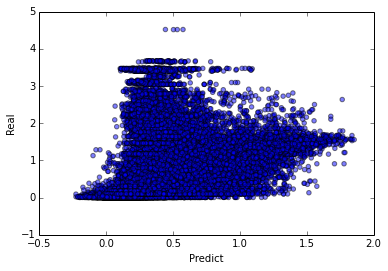

In [10]:
plt.scatter(y_val_lpo_predict, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict)

4021
786.193528042


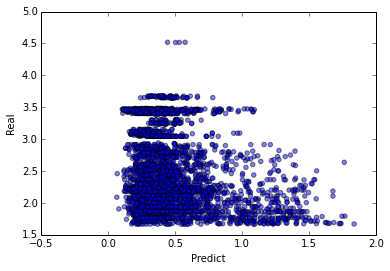

In [29]:
idx = y_val >45
plt.scatter(y_val_lpo_predict[idx.values], np.log10(1+y_val[idx]), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print idx.sum()
print LogPlusOne_score(y_val[idx], y_val_lpo_predict[idx.values])

142291
1.64387788222


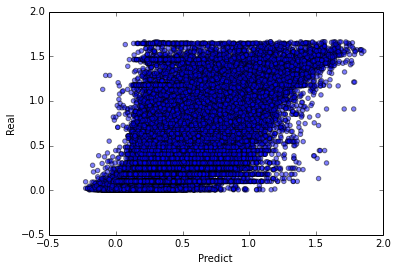

In [28]:
idx = y_val < 45
plt.scatter(y_val_lpo_predict[idx.values], np.log10(1+y_val[idx]), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print idx.sum()
print LogPlusOne_score(y_val[idx], y_val_lpo_predict[idx.values])

23.204501866


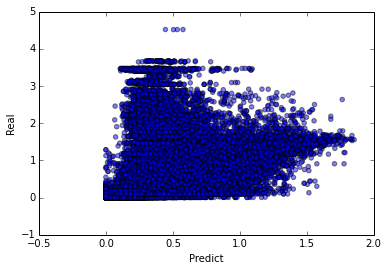

In [33]:
y_val_lpo_predict_new = y_val_lpo_predict.copy()
y_val_lpo_predict_new[y_val_lpo_predict_new<0] = 0
plt.scatter(y_val_lpo_predict_new, np.log10(1+y_val), alpha=0.5)
plt.xlabel('Predict')
plt.ylabel('Real')
print LogPlusOne_score(y_val, y_val_lpo_predict_new)